In [1]:
import functools
import pandas
import numpy
import yfinance

import matplotlib
import matplotlib.pyplot as plt

# 1 Introduction

Factor models can be used to decompose the risk and returns of an asset (or a collection of assets).

Essentially, we express the returns of a universe of assets in the following form,

$$ R_{i}^{t} = \alpha_{i}^{t} + \sum_{i=1}^{N} \beta_{ij}^{t} F_{j}^{t} + \epsilon_{i}^{t} $$

where,

* $R_{i}^{t}$ is the return of asset $i$ at time $t$
* $\beta_{ij}^{t}$ is the loading on factor $j$ from asset $i$ at time $t$
* $F_{j}^{t}$ is the factor return of factor $j$ at time $t$
* $\alpha_{i}^{t}$ is the expected idiosyncratic return of asset $i$ at time $t$
* $\epsilon_{i}^{t}$ is a noise term.

In this notebook, we'll explore creating a sector factor model from two different approaches:

* A "fundamental" approach where we specify the known sector loadings of each asset and estimate the factor returns.
* A "time-series" approach where we estimate the factor loadings by using sector ETFs as a proxy for factor returns.

We'll use S&P 500 constituents and GICS Sectors. 

### Helper Methods

In [2]:
def simple_returns(prices):
    return prices.pct_change().dropna(axis=0, how="all").fillna(value=0)

def cumulative_returns(returns, starting_value=1):
    return numpy.cumprod(1 + returns, axis=0) - 1

# 2 Fetch Data

## 2.1 Universe

In [3]:
df_spy = pandas.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]

In [4]:
spy_tickers = [
    ticker for ticker in df_spy["Symbol"].values.tolist()
    if ticker not in ["BRK.B", "BF.B"]
]

In [5]:
sector_etfs = {
    "Industrials": "XLI",
    "Energy": "XLE",
    "Financials": "XLF",
    "Information Technology": "XLK",
    "Materials": "XLB",
    "Consumer Discretionary": "XLY",
    "Consumer Staples": "XLP",
    "Health Care": "XLV",
    "Utilities": "XLU",
    "Real Estate": "XLRE",
    "Communication Services": "XLC",
}

## 2.2 Stock Data

In [6]:
# Download adjusted close prices using yfinance
yf = yfinance.Tickers(" ".join(spy_tickers))

df = yf.history(period="15y")

[*********************100%%**********************]  501 of 501 completed


Extract some additional data for each ticker

In [7]:
market_caps = pandas.Series({
    ticker: yf_ticker.info.get("marketCap", 0)
    for ticker, yf_ticker in yf.tickers.items()
})

sectors = df_spy.set_index(keys=["Symbol"]).loc[spy_tickers]["GICS Sector"]

In [8]:
# Convert prices to returns
stock_returns = simple_returns(df["Close"])

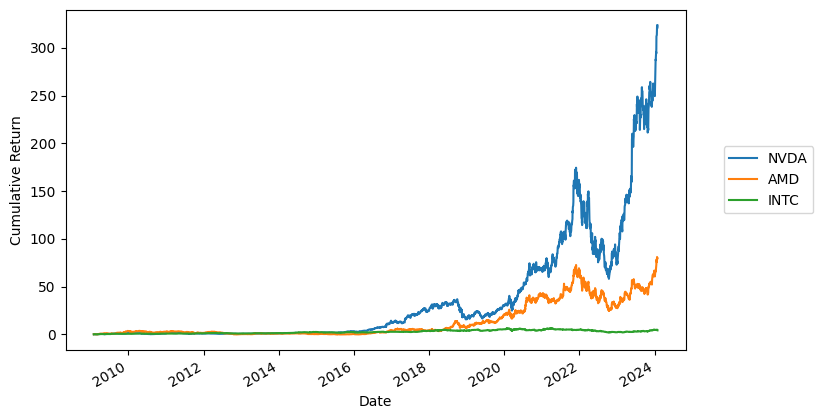

In [9]:
f, ax = plt.subplots(1, 1, figsize=(8, 5))

cumulative_returns(stock_returns[['NVDA', 'AMD', 'INTC']]).plot(ax=ax)
ax.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
ax.set_ylabel("Cumulative Return");

## 2.3 Sector Data

In [10]:
df_spy.set_index(keys=["Symbol"])["GICS Sector"].unique()

array(['Industrials', 'Health Care', 'Information Technology',
       'Utilities', 'Financials', 'Materials', 'Consumer Discretionary',
       'Real Estate', 'Communication Services', 'Consumer Staples',
       'Energy'], dtype=object)

In [11]:
# Download adjusted close prices using yfinance
sector_prices = yfinance.download(" ".join(sector_etfs.values()))['Adj Close']

[*********************100%%**********************]  11 of 11 completed


In [12]:
sector_returns = (
    simple_returns(sector_prices)
    .rename(columns={etf: name for name, etf in sector_etfs.items()})
)

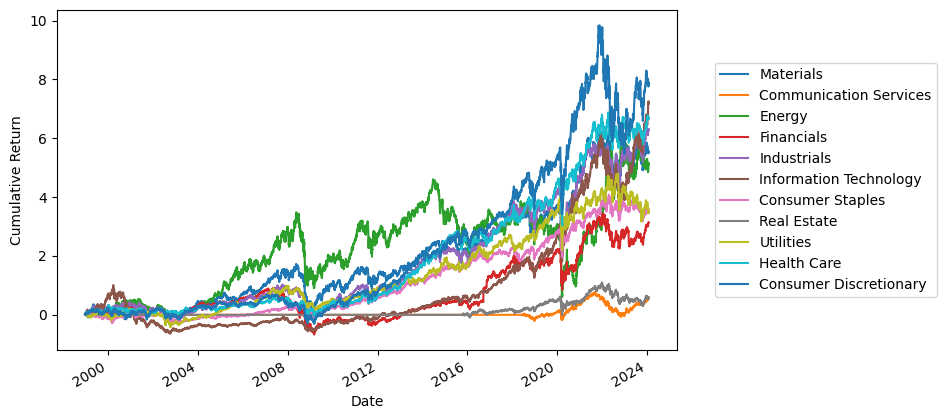

In [13]:
f, ax = plt.subplots(1, 1, figsize=(8, 5))

cumulative_returns(sector_returns).plot(ax=ax)
ax.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
ax.set_ylabel("Cumulative Return");

# 3 Fundamental Approach

In the case of the fundamental approach, we are given the loadings matrix $B$ and wish to estimate the factor returns.

The estimation problem is a weighted least-squares problem,

$$ \min_{F} \left( R - B F \right)^T W \left(R - B F \right) $$

The matrix $W$ is diagonal and positive definite. Setting $W = \Omega_{\epsilon}^{-1}$ results in an unbiased estimator of $F$ with lowest estimation error but since we do not know $W = \Omega_{\epsilon}^{-1}$ in advance, it is common to set $W$ to be a diagonal matrix with diagonal values equal to the square root of the market cap of each stock. That is $W_{ii} = \left( \text{market cap}_i \right)^{1/2} $.

The solution is given by,

$$ \hat{F} = \left(B^T W B \right)^{-1} B W R $$

and

$$ \hat{\epsilon} = \left( I - B (B^T W B)^{-1} B^T W \right) R $$

Note that the i'th row of $\left(B^T W B \right)^{-1} B W$ can be interpreted as a series of portfolio weights that mimic the i'th factor.

Note that as we only have access to the latest market capitalisation of each stock from `yfinance` which is problematic in a production environment due to

* the matrix $W$ being a source of information leakage (a future market cap value is in use)
* the factor mimicking portfolios do not vary in time as $W$ does not vary in time (the market cap value is static)

A resolution is to solve the ordinary least squares problem by setting $W = I$. 

Let's solve the above problem over a fixed time period.

In [14]:
class FundamentalFactorModel:

    def __init__(self, market_caps, sector_loadings):
        self.market_caps = market_caps
        self.sector_loadings = sector_loadings

        self.W = (
            pandas.DataFrame(
                data=numpy.diag(numpy.sqrt(self.market_caps)),
                index=market_caps.index,
                columns=market_caps.index,
            )
            .sort_index(axis=0)
            .sort_index(axis=1)
        )

        self.B = (
            self.sector_loadings
            .to_frame("Sector")
            .assign(Loading=1)
            .set_index(keys=["Sector"], append=True)
            .unstack(1)
            ["Loading"]
            .fillna(value=0)
        )

    def fit(self, returns):
        """Fit the model; calculate factor mimicking portfolios and factor returns"""

        R = returns.fillna(value=0)
        
        # Solve for factor mimicking portfolios
        fmp = numpy.linalg.solve(self.B.T @ self.W @ self.B, self.B.T @ self.W)

        self.fmp = pandas.DataFrame(
            data=fmp,
            index=self.B.columns,
            columns=returns.columns
        ).T
        
        # Solve for factor returns
        factor_returns = numpy.linalg.solve(self.B.T @ self.W @ self.B, self.B.T @ self.W @ R.T)
        
        self.factor_returns = pandas.DataFrame(
            data=factor_returns,
            columns=returns.index,
            index=self.B.columns
        ).T

        return self

In [15]:
ffm = FundamentalFactorModel(market_caps, sectors)

In [16]:
ffm = ffm.fit(stock_returns)

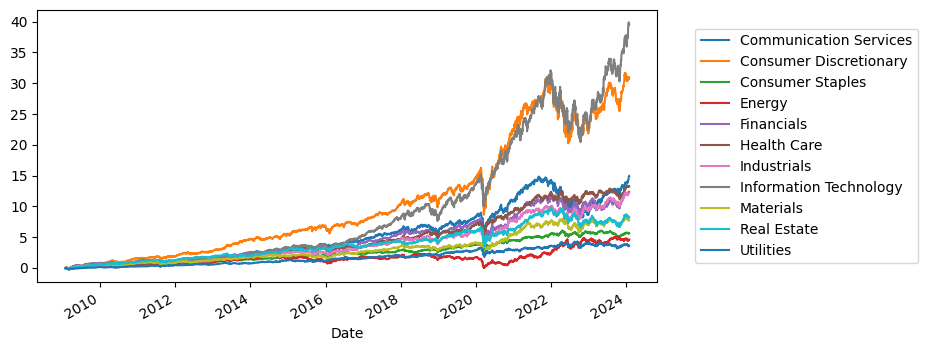

In [17]:
f, ax = plt.subplots(figsize=(8, 4))

cumulative_returns(ffm.factor_returns).plot(ax=ax)
ax.legend(loc="center left", bbox_to_anchor=(1.05, 0.5));

In [18]:
ffm.fmp[ffm.fmp["Communication Services"] != 0]["Communication Services"]

CHTR     0.028936
CMCSA    0.052617
DIS      0.051530
EA       0.023615
FOX      0.015006
FOXA     0.014988
GOOG     0.169266
GOOGL    0.169385
IPG      0.013785
LYV      0.017517
META     0.124033
MTCH     0.012507
NFLX     0.061280
NWS      0.014620
NWSA     0.014622
OMC      0.016392
PARA     0.011700
T        0.042905
TMUS     0.053943
TTWO     0.020593
VZ       0.051371
WBD      0.019390
Name: Communication Services, dtype: float64

# 4 Time-Series Approach

In the case of the time-series approach, we are given the factor returns $R$ and wish to estimate the loadings $B$ of each asset to the factors. 

Again, the estimation problem can be viewed as a least squares problem,

$$ \min_{B} \left( R - B F \right)^T \left(R - B F \right) $$

The solution is given by,

$$ \hat{B} = \left(F^T F \right)^{-1} F R $$

and

$$ \hat{\epsilon} = \left( I - F (F^T F)^{-1} F^T \right) R $$

Note that the loadings matrix $B$ is estimated over a date range. We may anticipate the loading values to change in time and not be static, therefore it is common to solve the above problem using a rolling window, therefore using the latest $N$ observations up to day $T$ to estimate the loadings for day $T+1$.

Due to the Communication Services ETF `XLC` beginning mid 2018, we perform this regression from 2019 onwards.

Let's solve the problem.

In [19]:
class TimeSeriesFactorModel:

    def __init__(self, sector_returns, training_period=126):
        self.sector_returns = sector_returns
        self.training_period = training_period

    def fit(self, returns):
        """Fit the model; calculate the factor loadings"""


        out = []
        n_obs = returns.shape[0]
        
        for ix in range(self.training_period, n_obs - 1):

            X_train = returns.iloc[ix-self.training_period:ix]
            date = returns.index[ix]
            
            # Solve
            l = self._fit_period(X_train)

            out.append(
                l.assign(Date=date).set_index(keys=["Date"], append=True)
            )

        self.loadings = pandas.concat(out, axis=0)
        
        return self

    def _fit_period(self, returns):
        """Helper method to calculate factor loadings for a single period"""

        R = returns.fillna(value=0)
        F = sector_returns.loc[R.index]
        
        # Solve for loadings
        L = numpy.linalg.solve(F.T @ F, F.T @ R)

        return pandas.DataFrame(
            data=L,
            index=F.columns,
            columns=stock_returns.columns,
        ).T

In [20]:
tsfm = TimeSeriesFactorModel(sector_returns)

In [21]:
stock_returns_clipped = stock_returns.loc["2019-01-01":]

In [22]:
tsfm = tsfm.fit(stock_returns_clipped)

Let's examine the loadings for a couple of stocks...

In [23]:
def generate_loadings_chart(loadings, symbol):

    f, ax = plt.subplots(1, 1, figsize=(8, 4))
    
    l = loadings.loc[symbol]
    
    l.plot(ax=ax)
    ax.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
    ax.set_title(f"Sector Loadings for {symbol}")
    ax.set_ylabel("Loading")
    
    ymax = l.abs().max().max() * 1.2
    ax.set_ylim(-ymax, ymax)    
    
    ax.fill_between(x=l.index, y1=-0.5, y2=0.5, alpha=0.1, color="grey")

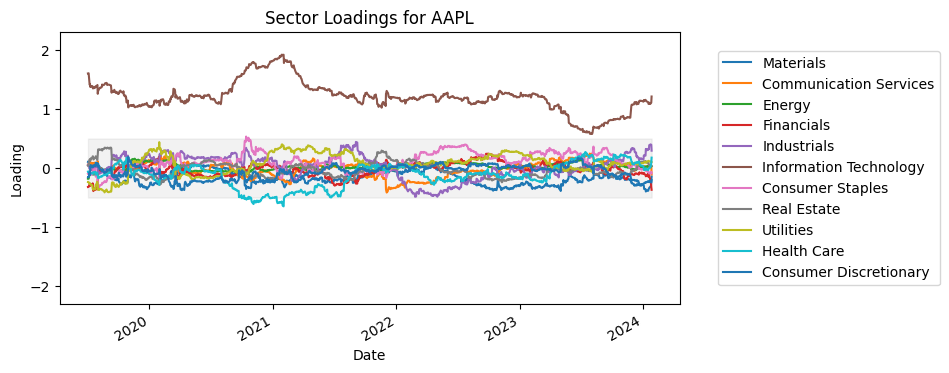

In [24]:
generate_loadings_chart(tsfm.loadings, "AAPL")

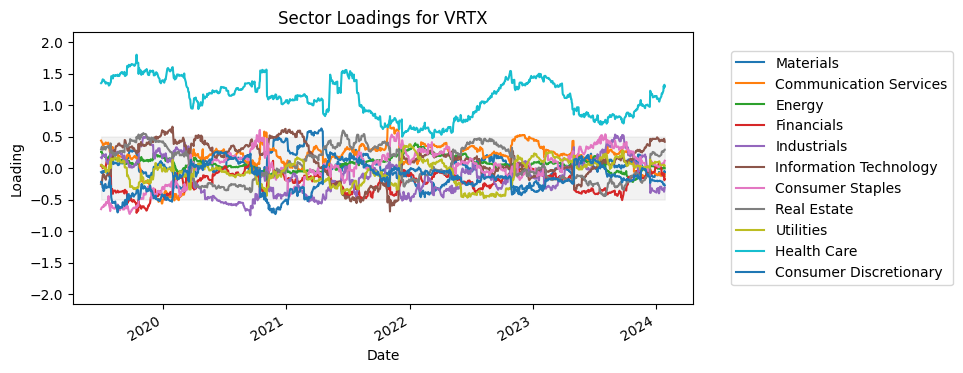

In [25]:
generate_loadings_chart(tsfm.loadings, "VRTX")

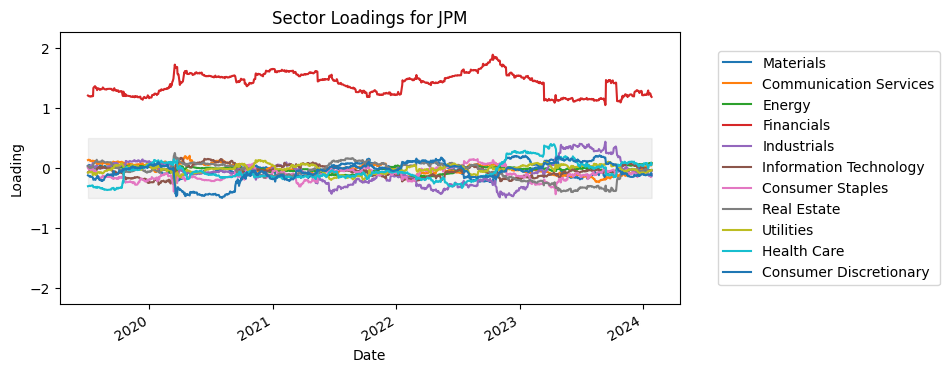

In [26]:
generate_loadings_chart(tsfm.loadings, "JPM")

So in each case there is a dominant loading corresponding to the sector of the company (as we would anticipate) with non-zero loadings on other sector factors.

# 5 Comparison

Let's examine the difference between the return attribution of the fundamental and time-series models.

In [27]:
def calculate_factor_attribution(tsfm, symbol):
    """Calculate the return attributed to factors for a given symbol"""

    return (
        tsfm.loadings
        .loc[symbol]
        .shift(1)
        .dropna()
        .melt(
            var_name="Sector",
            value_name="Loading",
            ignore_index=False)
        .set_index(keys=["Sector"], append=True)
        .join(
            tsfm.sector_returns
            .melt(
                var_name="Sector",
                value_name="Return_",
                ignore_index=False)
            .set_index(keys=["Sector"], append=True)
        )
        .assign(Return=lambda x: x["Loading"] * x["Return_"])
        .groupby(level=[0, 1])
        .agg({"Return": "sum"})
    )

In [28]:
wr = calculate_factor_attribution(tsfm, "AAPL")

First, we can examine the returns attributed to each sector in the time-series model. We observe that `Information Technology` is the largest driver of returns.

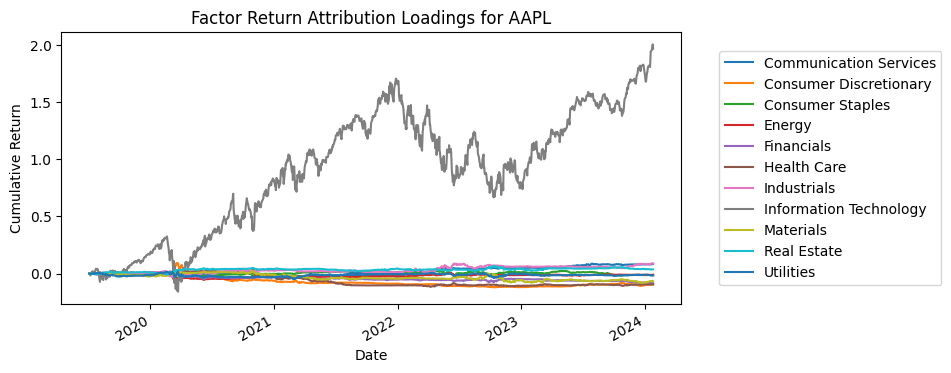

In [29]:
f, ax = plt.subplots(1, 1, figsize=(8, 4))

wr.unstack(1)["Return"].apply(cumulative_returns).plot(ax=ax)
ax.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
ax.set_title(f"Factor Return Attribution Loadings for AAPL")
ax.set_ylabel("Cumulative Return");

We can also compare the difference between the Fundamental and the Time-Series approach.

Text(0, 0.5, 'Cumulative Return')

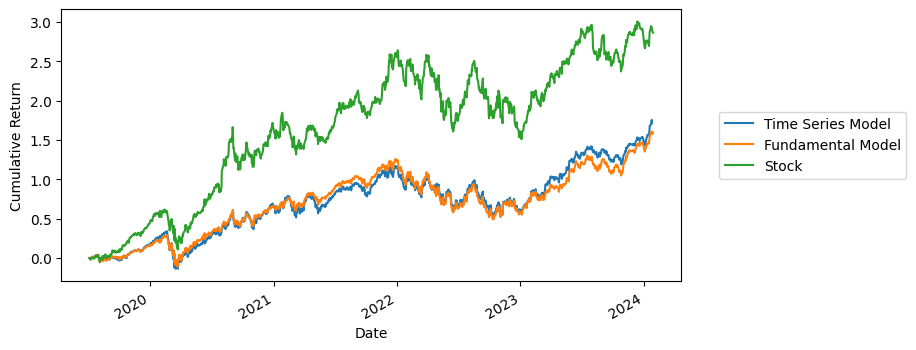

In [30]:
f, ax = plt.subplots(1, 1, figsize=(8, 4))

symbol = "AAPL"

idx_start = wr.index.get_level_values(0)[0]

(
    wr
    .groupby(level=0)
    .sum()
    .apply(cumulative_returns)
    ["Return"]
).plot(ax=ax, label="Time Series Model")

(
    sector_returns
    .loc[idx_start:]
    .apply(cumulative_returns)
    [sectors.loc[symbol]]
).plot(ax=ax, label="Fundamental Model")

cumulative_returns(stock_returns_clipped["AAPL"].loc[idx_start:]).plot(label="Stock")

ax.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
ax.set_ylabel("Cumulative Return")